In [2]:
#import libraries
import os
import random as rd
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import matplotlib as mpl
import keras.backend as K
import pandas as pd
import logomaker as lm
import seaborn as sns
import math as mt

2023-04-17 15:57:01.931486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 15:57:02.003606: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 15:57:02.337514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell3/anaconda3/envs/workenv/lib/
2023-04-17 15:57:02.337549: W tensorflow/compiler/xla/str

In [3]:
#load all chrs
X_2L=np.load('/home/florian/projet/r6.16/seq.npz')['2L']
X_2R=np.load('/home/florian/projet/r6.16/seq.npz')['2R']
X_3L=np.load('/home/florian/projet/r6.16/seq.npz')['3L']
X_3R=np.load('/home/florian/projet/r6.16/seq.npz')['3R']
X_4=np.load('/home/florian/projet/r6.16/seq.npz')['4']
X_X=np.load('/home/florian/projet/r6.16/seq.npz')['X']
X_Y=np.load('/home/florian/projet/r6.16/seq.npz')['Y']

In [4]:
# create scATAC values for each chr
cut=50

Y_KC=np.load('/home/florian/projet/cell_types/scATACseq_KC_G.dedup.no_blacklist.RPGCnormalized.bw.npz')['2L'][0]
Y_KC[Y_KC >= cut] = cut
Y_KC=Y_KC/cut

Y_T1=np.load('/home/florian/projet/cell_types/scATACseq_T1.dedup.no_blacklist.RPGCnormalized.bw.npz')['2L'][0]
Y_T1[Y_T1 >= cut] = cut
Y_T1=Y_T1/cut

pred_KC=np.load('/home/florian/projet/models/preds_new_cut_KC_G.npz')['pred2L']
pred_T1=np.load('/home/florian/projet/models/preds_new_cut_T1.npz')['pred2L']


start = 1316100
stop = start + 40000

start = 1702700
stop = start + 40000

start = 1808500
stop = start + 40000

BEST:
start = 1712500
stop = start + 20000


(0.0, 1.0)

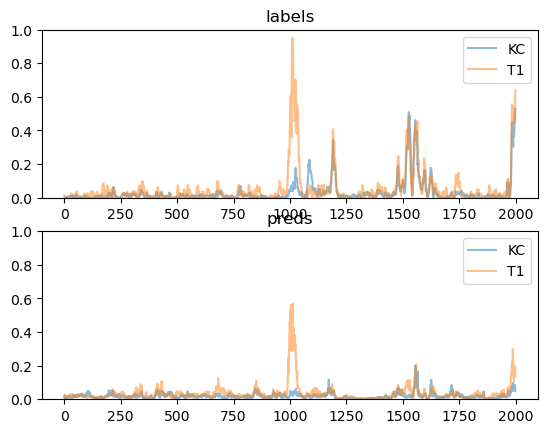

In [264]:
start = 1712500
stop = start + 20000

plt.subplot(2,1,1)
plt.plot(Y_KC[start:stop:10],alpha=0.5,label="KC")
plt.plot(Y_T1[start:stop:10],alpha=0.5,label="T1")
plt.title('labels')
plt.legend()
plt.ylim(0,1)

plt.subplot(2,1,2)
plt.plot(pred_KC[start//10:stop//10],alpha=0.5,label="KC")
plt.plot(pred_T1[start//10:stop//10],alpha=0.5,label="T1")
plt.title('preds')
plt.legend()
plt.ylim(0,1)


In [287]:
from keras.models import load_model
model_name='new_cut_weightless'
model2 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

In [18]:
def compute_saliency_map(input_seq, model):
    # Compute the gradients of the output with respect to the input
    input_seq=tf.cast(input_seq,tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_seq)
        output = model(tf.expand_dims(input_seq,0))
    grads = tape.gradient(output, input_seq)
    

    # Compute the saliency map
    saliency_map = grads #tf.multiply(input_seq, grads)

    # Sum the saliency map over the channel dimension
    saliency_map = tf.reduce_sum(saliency_map, axis=-1)
    return saliency_map

def compute_saliency_channels(input_seq, model):
    # Compute the gradients of the output with respect to the input
    input_seq=tf.cast(input_seq,tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_seq)
        output = model(tf.expand_dims(input_seq,0))
    grads = tape.gradient(output, input_seq)

    # Compute the saliency map
    saliency_map = grads #tf.multiply(input_seq, grads)
    
    return saliency_map

In [7]:
def fast_pred(input,model):
    return model(tf.expand_dims(tf.cast(input,tf.float32),0))

def fast_pred_seq(input,window_start,model,size=2001):
    X=[]
    for i in range(window_start,window_start+size):
        X.append(np.array(fast_pred(input[i-(size//2):i+(size//2)+1],model))[0])
    return(X)

In [6]:
def get_max(array,n):
    return ((-array).argsort()[:n])

def get_min(array,n):
    return (array.argsort()[:n])

In [5]:
def mutation(window_start,chr, vals, size=2001):
    mut=np.copy(chr)
    for i in vals:
        if 0 < i <= size:
            mut[i+window_start]=np.roll(mut[i+window_start],1)
        elif 2001 < i <= 2*size:
            mut[i+window_start-size]=np.roll(mut[i+window_start-size],1)
        elif 4002 < i <= 3*size:
            mut[i+window_start-2*size]=np.roll(mut[i+window_start-2*size],1)
        else:
            mut[i+window_start-3*size]=np.roll(mut[i+window_start-3*size],1)
    return mut

def aimed_mutation(window_start,chr, vals,size=2001):
    mut=np.copy(chr)
    for i in vals:
        if 0 < i <= size:
            mut[i+window_start]=[1,0,0,0]
        elif 2001 < i <= 2*size:
            mut[i+window_start-size]=[0,1,0,0]
        elif 4002 < i <= 3*size:
            mut[i+window_start-2*size]=[0,0,1,0]
        else:
            mut[i+window_start-3*size]=[0,0,0,1]
    return mut

In [4]:
def window_map(input,window_start,model,size=2001):
    model=model
    Y=np.zeros(size*2)
    for i in range (-(size//2),size//2):
        x=np.array(compute_saliency_map(tf.cast(input[window_start+i:window_start+size+i],tf.float32),model))
        y=np.concatenate((np.zeros(size//2+i),x,np.zeros(size//2+1-i)))
        Y=np.vstack([Y,y])
    return(Y)

In [584]:
#pic !!!
start =489_700
stop = start + 2_001

In [17]:
#flat
start =500_000
stop = start + 2_001

(0.0, 1.0)

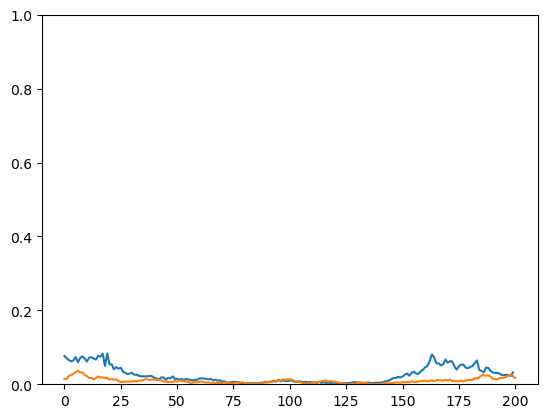

In [14]:
plt.plot(pred2L[start//10:stop//10])
plt.plot(Y_2L[start:stop:10])
plt.ylim(0,1)

In [18]:
fast_2L=fast_pred_seq(X_2L,start,model2)

2023-04-05 13:22:56.923993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-05 13:22:57.285786: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-05 13:22:57.612634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [19]:
MAP=window_map(X_2L,start,model2)

In [ ]:
saliency_map=np.array(compute_saliency_channels(X_2L[start:stop],model2))

In [21]:
attr_map = saliency_map - np.mean(saliency_map, axis=1, keepdims=True)

In [22]:
saliencyDF=pd.DataFrame(saliency_map[700:1300], columns=["A", "C", "G", "T"])

In [23]:
attrDF=pd.DataFrame(attr_map[700:1300], columns=["A", "C", "G", "T"])

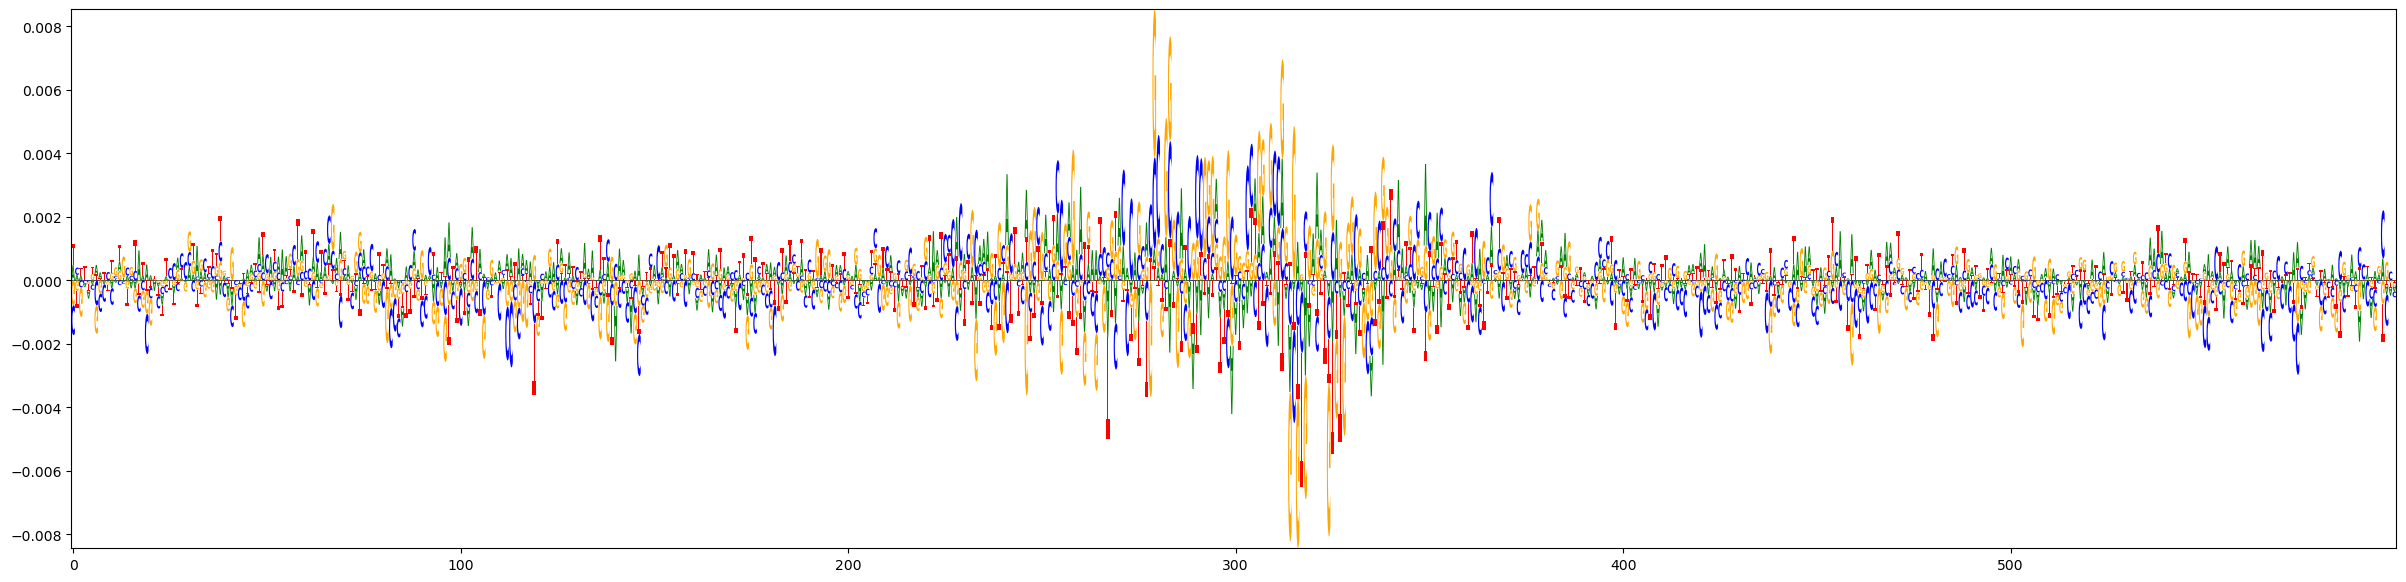

In [24]:
lm.Logo(saliencyDF, figsize=(30, 7))

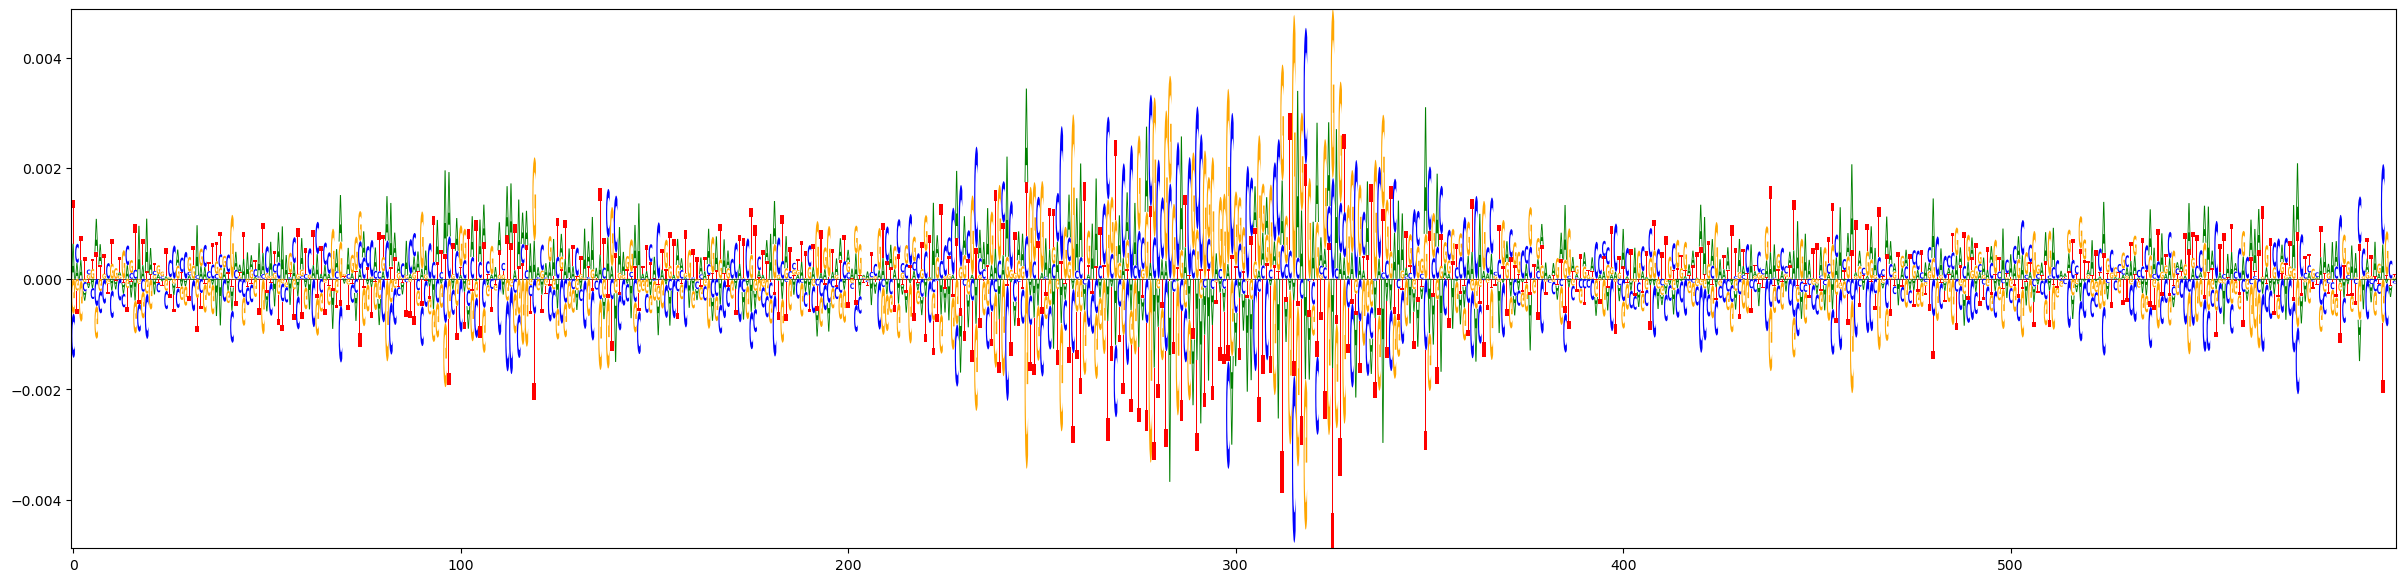

In [25]:
lm.Logo(attrDF, figsize=(30, 7))

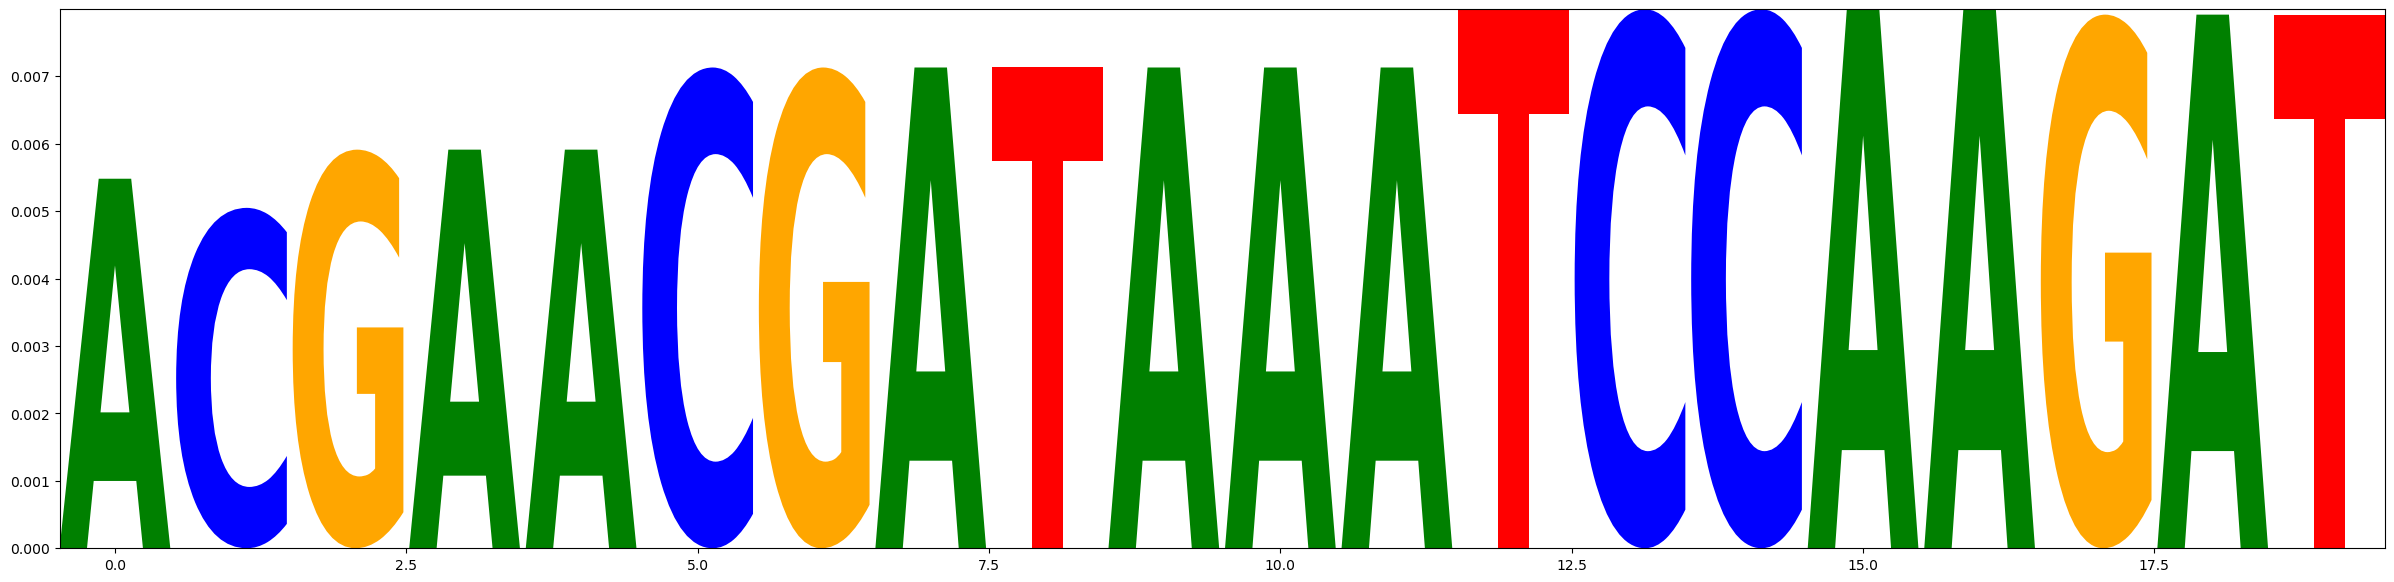

In [190]:
midp = start+(stop-start)
df = pd.DataFrame(X_2L[midp:midp+20,:]*Y_2L[midp:midp+20].reshape((-1,1)), columns=["A", "C", "G", "T"])
lm.Logo(df, figsize=(30, 7))

In [20]:
sal=compute_saliency_channels(X_2L[start:stop],model2)

In [21]:
vals=np.concatenate((np.array(sal[:,0]),np.array(sal[:,1]),np.array(sal[:,2]),np.array(sal[:,3])))

In [23]:
vals_idx=get_max(vals,10)

In [24]:
vals_idx_2=get_min(vals,10)

In [25]:
M_2L=mutation(start,X_2L,vals_idx)

In [26]:
M_2L_2=mutation(start,X_2L,vals_idx_2)

In [43]:
fast_M2L=fast_pred_seq(M_2L,start,model2)

In [28]:
fast_M2L_2=fast_pred_seq(M_2L_2,start,model2)

In [69]:
saliency_map=compute_saliency_channels(X_2L[start:stop],model2)

In [70]:
saliency= saliency_map - np.mean(saliency_map, axis=1, keepdims=True)

In [71]:
saliency=saliency-(saliency*X_2L[start:stop])

In [ ]:
#highest value method
mod_loop=np.copy(X_2L)
sal_loop=compute_saliency_channels(mod_loop[start:stop],model2)
mod_sal=sal_loop-(sal_loop*X_2L[start:stop])
mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
mod_vals_idx=get_max(mod_vals,10)
mod_M_2L=mutation(start,mod_loop,mod_vals_idx)
best_pred=fast_pred(mod_M_2L[start:stop],model2)
L=[]
L2=[]
for i in range(10_000):
    mod_loop=np.copy(mod_M_2L)
    sal_loop=compute_saliency_channels(mod_loop[start:stop],model2)
    mod_sal=sal_loop-(sal_loop*X_2L[start:stop])
    mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
    mod_vals_idx=get_max(mod_vals,10)
    mod_M_2L=mutation(start,mod_loop,mod_vals_idx)
    f_pred=fast_pred(mod_M_2L[start:stop],model2)
    L2.append(fast_pred)
    if  f_pred> best_pred:
        L.append(i)
        best_pred=fast_pred(mod_M_2L[start:stop],model2)
        omega_pred=mod_M_2L
fast_mod_M2L=fast_pred_seq(mod_M_2L,start,model2)
print(L)

In [52]:
a = np.random.rand(24).reshape(6, 4)
# a[a.max(axis=1).argmax()].argmax()
print(a)
pos, base = np.unravel_index(a.argmax(), a.shape)
a[pos] = [0, 0, 0, 0]
a[pos, base] = 1

[[0.14051072 0.70663169 0.01455366 0.16712703]
 [0.1617458  0.66747977 0.0963812  0.39572511]
 [0.92695716 0.42208239 0.88396882 0.62866975]
 [0.69245716 0.90033887 0.57504854 0.85440496]
 [0.22414037 0.6983123  0.27750515 0.32217931]
 [0.20577837 0.27067669 0.32509155 0.89197968]]


(2, 0)

In [153]:
#highest value aimed method
mod_loop=np.copy(X_2L)
sal_loop=compute_saliency_channels(mod_loop[start:stop],model2)
mod_sal=sal_loop-(sal_loop*X_2L[start:stop])
mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
mod_vals_idx=get_max(mod_vals,1)
mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
best_pred=fast_pred(mod_M_2L[start:stop],model2)
L=[]
L2=[]
for i in range(100):
    mod_loop=np.copy(mod_M_2L)
    sal_loop=compute_saliency_channels(mod_loop[start:stop],model2)
    mod_sal=sal_loop-(sal_loop*X_2L[start:stop])
    mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
    mod_vals_idx=get_max(mod_vals,1)
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    f_pred=fast_pred(mod_M_2L[start:stop],model2)
    L2.append(f_pred[0,0].numpy())
    if  f_pred> best_pred:
        L.append(i)
        best_pred=fast_pred(mod_M_2L[start:stop],model2)
        omega_pred=mod_M_2L
fast_mod_M2L=fast_pred_seq(mod_M_2L,start,model2)
print(L,L2)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 18, 19] [0.015536923, 0.019863779, 0.026584666, 0.028133124, 0.047258925, 0.08521515, 0.099020384, 0.12592396, 0.17858039, 0.15062635, 0.16428243, 0.18679546, 0.2185971, 0.23716597, 0.37561646, 0.39275885, 0.48776138, 0.479657, 0.54135174, 0.5707609, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0.55662644, 0

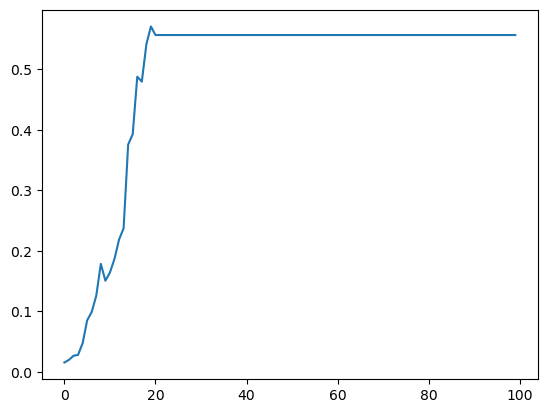

In [156]:
plt.plot(L2)

In [46]:
#weighted probabilities method
mod_loop=np.copy(X_2L)
sal_loop=compute_saliency_channels(mod_loop[start:stop],model2)
mod_sal=sal_loop-(sal_loop*X_2L[start:stop])
mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
mod_vals_idx=get_max(mod_vals,1)
mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
best_pred=fast_pred(mod_M_2L[start:stop],model2)
L=[] #upgrades
L2=[] #pred values
L3=[] #mutation idx
for i in range(2000):
    mod_loop=np.copy(mod_M_2L)
    sal_loop=compute_saliency_channels(mod_loop[start:stop],model2)
    sal_loop=sal_loop-(sal_loop*X_2L[start:stop])
    sal_loop=np.concatenate((np.zeros((900,4)),sal_loop[900:1100],np.zeros((901,4)))) #aim at center (200bp)
    mod_vals=np.concatenate((np.array(sal_loop[:,0]),np.array(sal_loop[:,1]),np.array(sal_loop[:,2]),np.array(sal_loop[:,3])))
    temp=mod_vals[mod_vals>=0]
    temp=(temp/sum(temp))
    mod_vals_value=rd.choices(mod_vals[mod_vals>=0], weights=temp, k=1)
    mod_vals_idx=np.where(mod_vals==mod_vals_value)[0]
    L3.append(mod_vals_idx)
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    f_pred=fast_pred(mod_M_2L[start:stop],model2)
    L2.append(f_pred[0,0].numpy())
    if  f_pred> best_pred:
        L.append(i)
        best_pred=fast_pred(mod_M_2L[start:stop],model2)
        omega_pred=mod_M_2L
fast_mod_M2L=fast_pred_seq(mod_M_2L,start,model2)
print(L)

[0, 3, 6, 8, 9, 11, 12, 17, 19, 20, 23, 24, 25, 27, 30, 32, 52, 53, 54, 55, 58, 60, 75, 77, 78, 79, 80, 87, 88, 89, 105, 106, 110, 111, 112, 114, 130, 131, 132, 133, 134, 135, 136, 137, 160, 177, 184, 185, 753, 754, 761, 762, 796, 822, 823, 828, 845, 846, 1499, 1520, 1998]


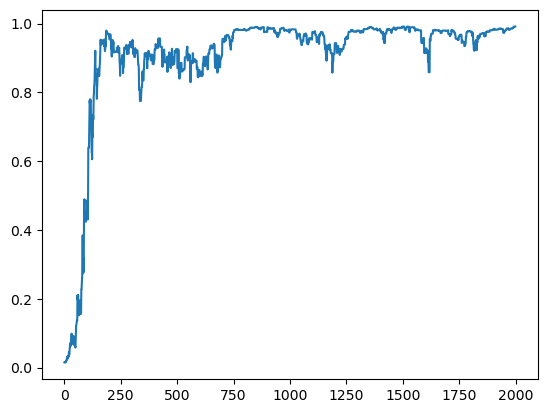

In [65]:
plt.plot(L2)

In [24]:
fast_mod_M2L=fast_pred_seq(omega_pred,start,model2)

Text(0.5, 1.0, '500000-502001')

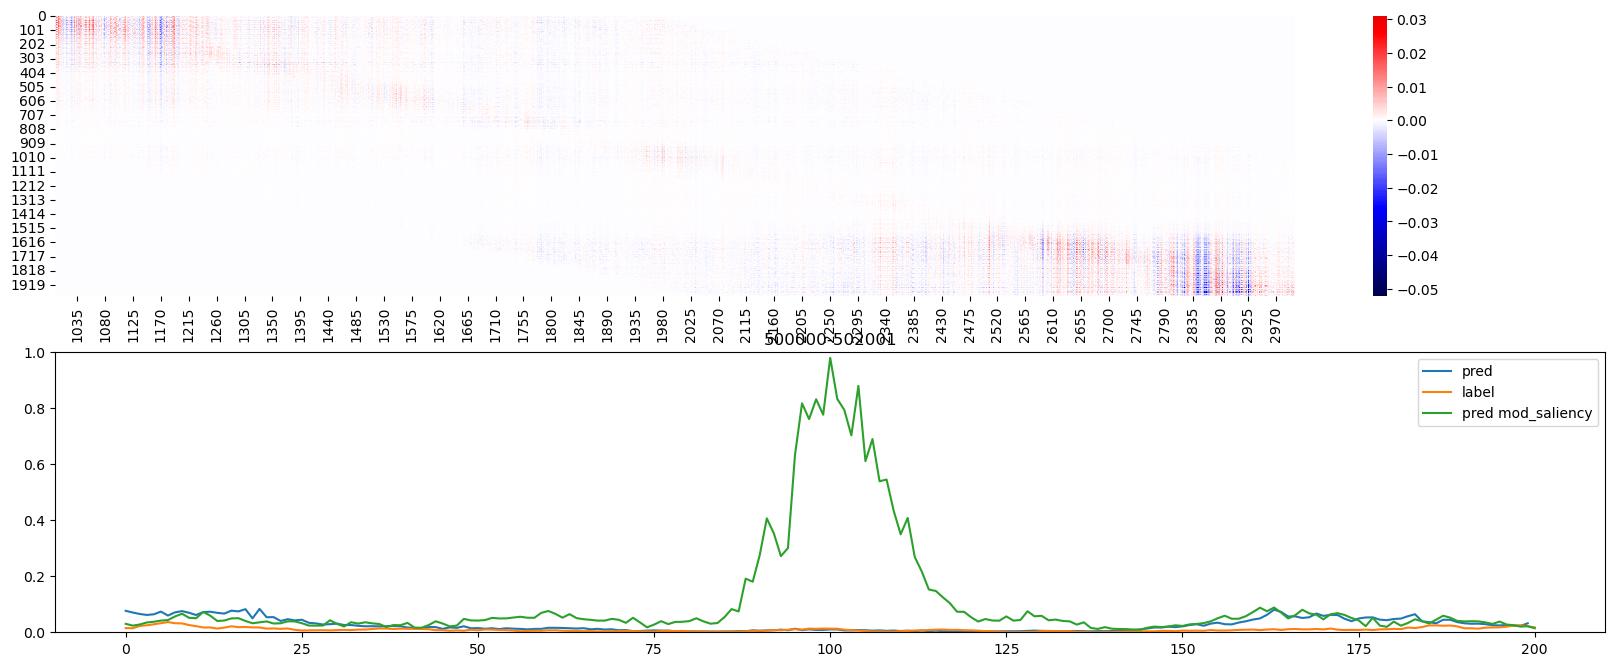

In [28]:
import seaborn as sns
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
sns.heatmap(MAP, cmap='seismic',center=0)
plt.xlim(1000,3001)

plt.subplot(2,1,2)
plt.plot(pred2L[start//10:stop//10],label='pred')
plt.plot(Y_2L[start:stop:10],label='label')
# plt.plot(fast_M2L[::10],label='pred mutation')
# plt.plot(fast_M2L_2[::10],label='pred mutation_2')
plt.plot(fast_mod_M2L[::10],label='pred mod_saliency')
plt.legend()
plt.ylim(0,1)
plt.title(str(start)+ '-' +str(stop))

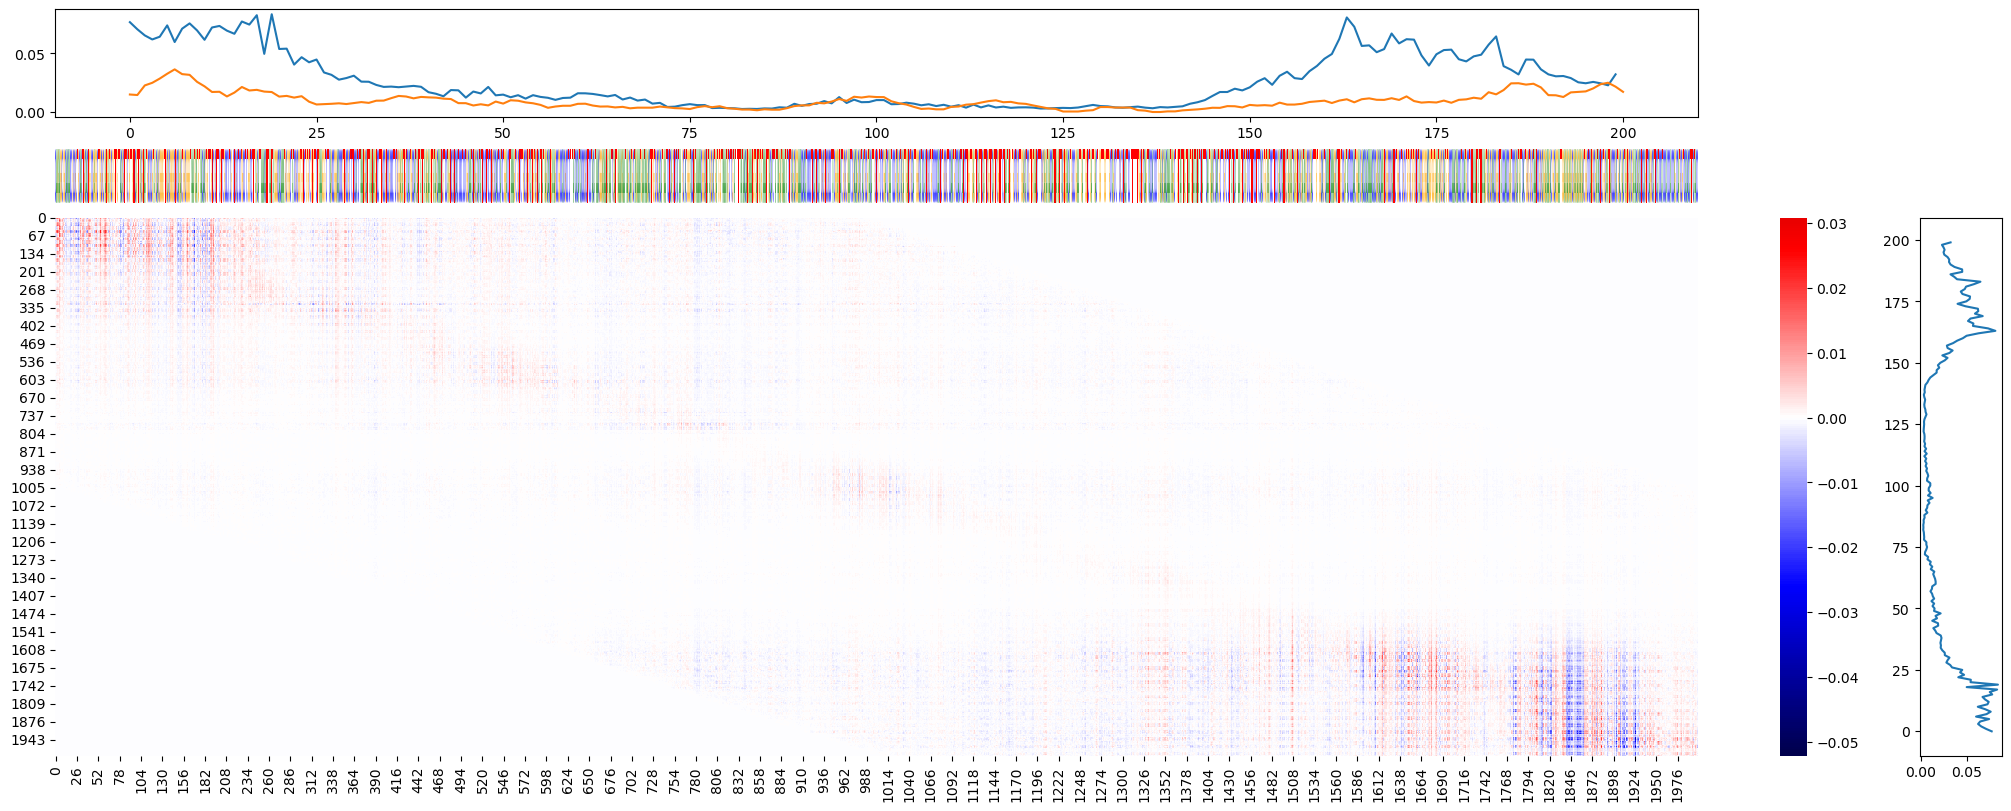

In [33]:
plot_start = start

plot_stop = stop

fig, axes = plt.subplots(3, 2, figsize=(20, 8),layout='constrained', gridspec_kw={'width_ratios': [20, 1], 'height_ratios': [2, 1, 10]})

fig.set_facecolor('w')
axes[0, 0].plot(pred2L[plot_start//10:plot_stop//10], label='pred')
axes[0, 0].plot(Y_2L[plot_start:plot_stop:10], label='label')

lm.Logo(pd.DataFrame(X_2L[plot_start:plot_stop], columns=list('ACGT')), ax=axes[1, 0])

axes[1, 0].set_axis_off()

sns.heatmap(MAP[:,1000:3001], cmap='seismic', center=0, ax=axes[2, 0])#,xticklabels=100, yticklabels=50)

axes[2, 1].plot(pred2L[start//10:stop//10], np.arange(200), label='predictions')

axes[0, 1].remove()
axes[1, 1].remove()
# axes[2, 1].remove()

plt.show()
plt.close()

(936.0, 1080.0)

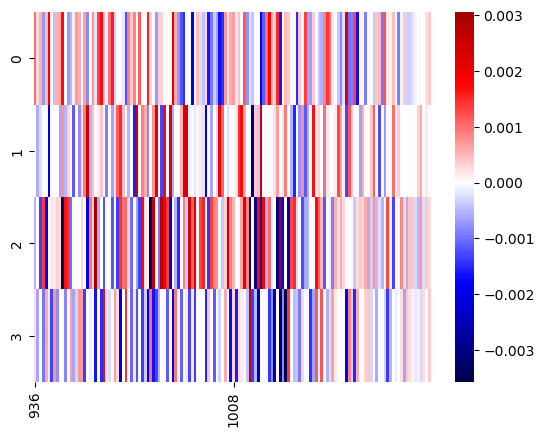

In [43]:
sns.heatmap(np.array(saliency).T, cmap='seismic',center=0)
plt.xlim(936,1080)

In [12]:
cut=500
Y_4=np.load('/home/florian/projet/scATACseq_14chr.npz')['4'][0]
Y_4[Y_4 >= cut] = cut
Y_4=Y_4/cut
pred100=np.load('/home/florian/projet/drosoSYNTH/preds_droso_synth.npz')['pred100']
predTATA=np.load('/home/florian/projet/drosoSYNTH/preds_droso_synth.npz')['predTATA']
X_4_TATA=np.load('/home/florian/projet/drosoSYNTH/seqTATA.npz')['chr4']
X_4_100=np.load('/home/florian/projet/drosoSYNTH/seq100.npz')['chr4']


In [11]:
start = 2000
stop = start + 2001

(2000.0, 4000.0)

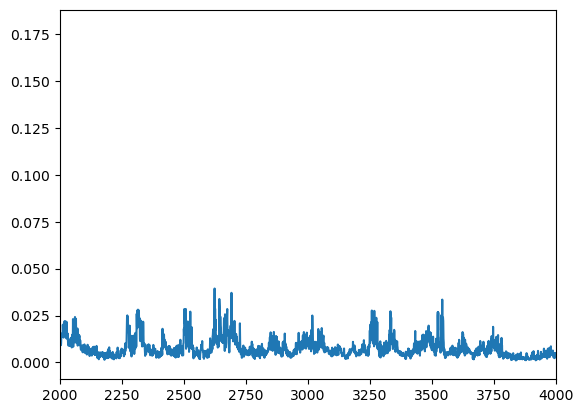

In [12]:
plt.plot(pred100)
plt.xlim(2000,4000)

In [31]:
MAP_100=window_map(X_4_100,start,model2)


2023-04-06 14:44:36.596132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-06 14:44:36.953388: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-06 14:44:37.278194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
from keras.models import load_model
model_name='new_cut_2001_KC_G'
modelKC = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T1'
modelT1 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

2023-04-17 15:57:57.829534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 15:57:57.832721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 15:57:57.832803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 15:57:57.833188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

(0.0, 1.0)

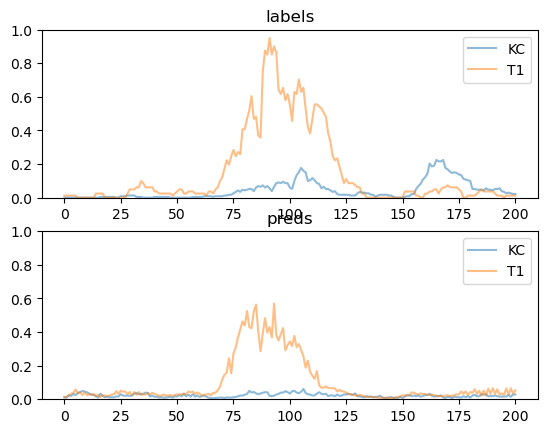

In [10]:
# create scATAC values for each chr
cut=50

Y_KC=np.load('/home/florian/projet/cell_types/scATACseq_KC_G.dedup.no_blacklist.RPGCnormalized.bw.npz')['2L'][0]
Y_KC[Y_KC >= cut] = cut
Y_KC=Y_KC/cut

Y_T1=np.load('/home/florian/projet/cell_types/scATACseq_T1.dedup.no_blacklist.RPGCnormalized.bw.npz')['2L'][0]
Y_T1[Y_T1 >= cut] = cut
Y_T1=Y_T1/cut

pred_KC=np.load('/home/florian/projet/models/preds_new_cut_KC_G.npz')['pred2L']
pred_T1=np.load('/home/florian/projet/models/preds_new_cut_T1.npz')['pred2L']

start=1721700
stop=start+2001

X_KC=pred_KC[start//10:stop//10+1]
X_T1=pred_T1[start//10:stop//10+1]

plt.subplot(2,1,1)
plt.plot(Y_KC[start:stop:10],alpha=0.5,label="KC")
plt.plot(Y_T1[start:stop:10],alpha=0.5,label="T1")
plt.title('labels')
plt.legend()
plt.ylim(0,1)

plt.subplot(2,1,2)
plt.plot(X_KC,alpha=0.5,label="KC")
plt.plot(X_T1,alpha=0.5,label="T1")
plt.title('preds')
plt.legend()
plt.ylim(0,1)

In [138]:
L=[]

for i in range(len(Y_KC)):
    if abs(Y_T1[i]-Y_KC[i])>0.6:
        L.append(i)

for i in range(len(L)-1):
    if abs(L[i]-L[i+1])<100:
        L[i]=0
L = [i for i in L if i != 0]
print(L) 

[259223, 516584, 949192, 959244, 1136150, 1722687, 1801016, 2004776, 2021256, 2202758, 2941931, 2942130, 3137024, 4237898, 4238115, 4340388, 4669689, 4702775, 4765406, 5671755, 5925183, 6055253, 6056778, 6740270, 6874467, 7711289, 7936219, 8825157, 8825698, 8861385, 9228695, 9285136, 9333405, 9564496, 9738186, 9753510, 11228394, 11570735, 11628896, 11763665, 11916607, 12316492, 12349991, 12386518, 13032660, 13068378, 13110546, 13322612, 13322734, 13577242, 14389382, 14412537, 14775860, 14776318, 15012852, 15013591, 15158120, 15235569, 15581379, 15831473, 16036789, 16099471, 16277014, 16547663, 16652675, 17776561, 19210645, 19342785, 19848303, 20126262, 20330462, 20960089, 21042330, 21078300, 21933506, 21933868]


(0.0, 10000.0)

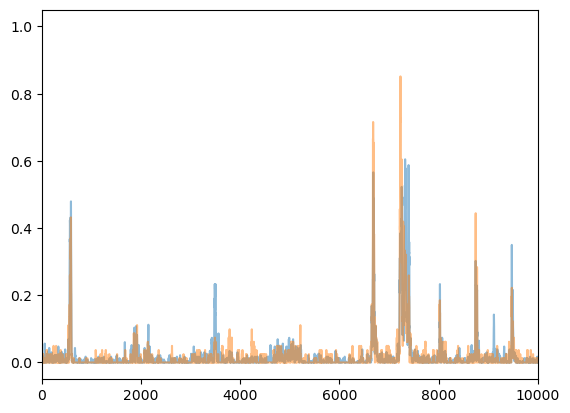

In [116]:
plt.plot(Y_KC[::10],alpha=0.5,label='KC')
plt.plot(Y_T1[::10],alpha=0.5,label='T1')
plt.xlim(0,10_000)


In [141]:
LT1, LKC = [], []
for i in range(len(Y_KC)):
    if Y_T1[i]>0.2:
        LT1.append(i)
    if Y_KC[i]>0.2:
        LKC.append(i)
for i in range(len(LKC)-1):
    if abs(LKC[i]-LKC[i+1])<100:
        LKC[i]=0
LKC = [i for i in LKC if i != 0]
for i in range(len(LT1)-1):
    if abs(LT1[i]-LT1[i+1])<100:
        LT1[i]=0
LT1 = [i for i in LT1 if i != 0]

In [142]:
Lc=[]
for i in LKC+LT1:
    if 0.8*Y_T1[i]>Y_KC[i]:
        Lc.append(i)

In [143]:
len(Lc)

2202

In [104]:
print(len(LKC),len(LT1),len(L))

2797 3113 76


(0.0, 1.0)

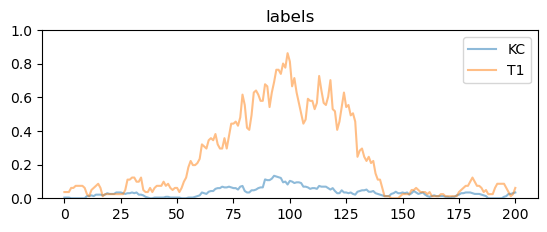

In [84]:
location = 4237878

plt.subplot(2,1,1)
plt.plot(Y_KC[location-1001:location+1001:10],alpha=0.5,label="KC")
plt.plot(Y_T1[location-1001:location+1001:10],alpha=0.5,label="T1")
plt.title('labels')
plt.legend()
plt.ylim(0,1)

(0.0, 1.0)

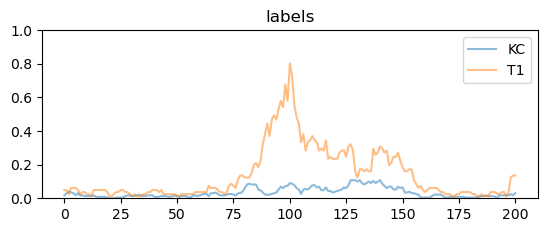

In [85]:
location = 4765395

plt.subplot(2,1,1)
plt.plot(Y_KC[location-1001:location+1001:10],alpha=0.5,label="KC")
plt.plot(Y_T1[location-1001:location+1001:10],alpha=0.5,label="T1")
plt.title('labels')
plt.legend()
plt.ylim(0,1)

In [16]:
start=1721700
stop=start+2001
fast_pred(X_2L[start:stop],modelT1)[0]


2023-04-17 11:20:38.583036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-17 11:20:38.945093: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-17 11:20:39.289453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.55067307], dtype=float32)>

In [405]:
#weighted probabilities method
mod_loop=np.copy(X_2L)
salKC=compute_saliency_channels(mod_loop[start:stop],modelKC)
salKC=salKC - np.mean(salKC, axis=1, keepdims=True)
salKC=salKC-(salKC*X_2L[start:stop])
salT1=compute_saliency_channels(mod_loop[start:stop],modelT1)
salT1=salT1-(salT1*X_2L[start:stop])
sal_loop=salKC*(1-salT1)
mod_sal=sal_loop
mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
mod_vals_idx=get_max(mod_vals,1)
mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
best_predKC=fast_pred(mod_M_2L[start:stop],modelKC)
best_predT1=fast_pred(mod_M_2L[start:stop],modelT1)
LKC=[] #upgrades
LT1=[] #upgrades
L2KC=[] #pred values
L2T1=[] #pred values
L3=[] #mutation idx
for i in range(2000):
    mod_loop=np.copy(mod_M_2L)
    salKC=compute_saliency_channels(mod_loop[start:stop],modelKC)
    salKC=salKC - np.mean(salKC, axis=1, keepdims=True)
    salKC=salKC-(salKC*X_2L[start:stop])
    salT1=compute_saliency_channels(mod_loop[start:stop],modelT1)
    salT1=salT1 - np.mean(salT1, axis=1, keepdims=True)
    salT1=salT1-(salT1*X_2L[start:stop])
    sal_loop=salKC*(1-salT1)
    sal_loop=sal_loop
    sal_loop=np.concatenate((np.zeros((900,4)),sal_loop[900:1100],np.zeros((901,4)))) #aim at center (200bp)
    mod_vals=np.concatenate((np.array(sal_loop[:,0]),np.array(sal_loop[:,1]),np.array(sal_loop[:,2]),np.array(sal_loop[:,3])))
    temp=mod_vals[mod_vals>=0]
    temp=(temp/sum(temp))
    mod_vals_value=rd.choices(mod_vals[mod_vals>=0], weights=temp, k=1)
    mod_vals_idx=np.where(mod_vals==mod_vals_value)[0]
    L3.append(mod_vals_idx)
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    
    f_predKC=fast_pred(mod_M_2L[start:stop],modelKC)
    L2KC.append(f_predKC[0,0].numpy())
    if  f_predKC > best_predKC:
        LKC.append(i)
        best_predKC=fast_pred(mod_M_2L[start:stop],modelKC)
        most_pred=mod_M_2L
    
    f_predT1=fast_pred(mod_M_2L[start:stop],modelT1)
    L2T1.append(f_predT1[0,0].numpy())
    if  f_predT1 < best_predT1:
        LT1.append(i)
        best_predT1=fast_pred(mod_M_2L[start:stop],modelT1)
        least_pred=mod_M_2L
        
#fast_mod_M2L=fast_pred_seq(mod_M_2L,start,model2)
print(L)

[0, 3, 6, 10, 11, 14, 16, 17, 18, 19, 21, 23, 24, 26, 27, 31, 32, 34, 35, 39, 46, 49, 54, 63, 67, 70, 72, 75, 77, 81, 91, 92, 98, 103, 104, 106, 109, 110, 111, 112, 114, 115, 116, 122, 125, 128, 130, 139, 141, 142, 164, 170, 286, 320, 323, 327, 556, 557, 563, 567, 568, 572, 574, 578, 611, 800, 806, 844, 845, 850, 856]


In [249]:
fast_mod_T1=fast_pred_seq(least_pred,start,modelT1)
fast_mod_KC=fast_pred_seq(least_pred,start,modelKC)


(0.0, 1.0)

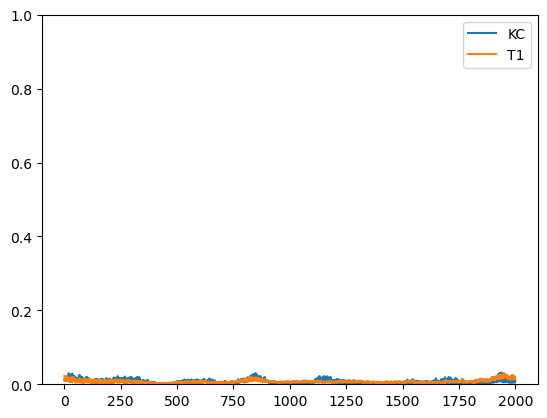

In [250]:
plt.plot(fast_mod_KC,label='KC')
plt.plot(fast_mod_T1,label='T1')
plt.legend()
plt.ylim(0,1)
# plt.xlim(900,950)

(2000.0, 4000.0)

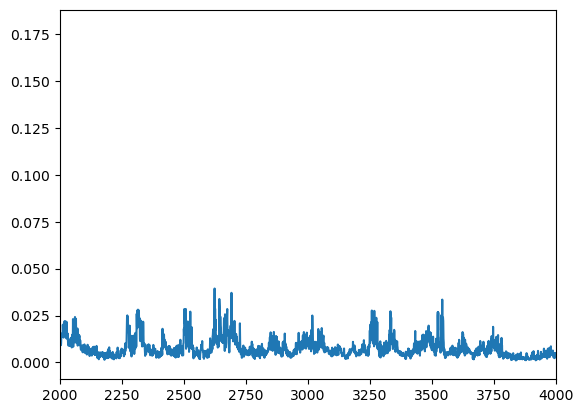

In [16]:
cut=500
Y_4=np.load('/home/florian/projet/scATACseq_14chr.npz')['4'][0]
Y_4[Y_4 >= cut] = cut
Y_4=Y_4/cut
pred100=np.load('/home/florian/projet/drosoSYNTH/preds_droso_synth.npz')['pred100']
X_4_100=np.load('/home/florian/projet/drosoSYNTH/seq100.npz')['chr4']
start = 2000
stop = start + 2001
plt.plot(pred100)
plt.xlim(2000,4000)

In [19]:
#weighted probabilities method
mod_loop=np.copy(X_4_100)
sal_loop=compute_saliency_channels(mod_loop[start:stop],modelKC)
sal_loop=sal_loop - np.mean(sal_loop, axis=1, keepdims=True)
mod_sal=np.array(sal_loop-(sal_loop*X_4_100[start:stop]))
mod_sal[mod_sal<0]=0
mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
mod_vals_idx=get_max(mod_vals,1)
mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
best_pred=fast_pred(mod_M_2L[start:stop],modelKC)
L=[] #upgrades
L2=[] #pred values
for i in range(2000):
    mod_loop=np.copy(mod_M_2L)
    sal_loop=compute_saliency_channels(mod_loop[start:stop],modelKC)
    sal_loop=sal_loop - np.mean(sal_loop, axis=1, keepdims=True)
    sal_loop=np.array(sal_loop-(sal_loop*X_4_100[start:stop]))
    sal_loop[sal_loop<0]=0
    sal_loop[:900] = 0
    sal_loop[1100:] = 0
    prob = sal_loop / np.sum(sal_loop)
    mod_vals = sal_loop.T.ravel()
    mod_vals_value=rd.choices(mod_vals, weights=prob.T.ravel(), k=1)
    mod_vals_idx=np.where(mod_vals==mod_vals_value)[0]
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    f_pred=fast_pred(mod_M_2L[start:stop],modelKC)
    L2.append(f_pred[0,0].numpy())
    if  f_pred> best_pred:
        L.append(i)
        best_pred=fast_pred(mod_M_2L[start:stop],modelKC)
        omega_pred=mod_M_2L
fast_mod_M2L=fast_pred_seq(mod_M_2L,start,modelKC)
print(L)

2023-04-17 16:00:06.825937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-17 16:00:07.201463: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-17 16:00:07.526425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


KeyboardInterrupt: 

(0.0, 1.0)

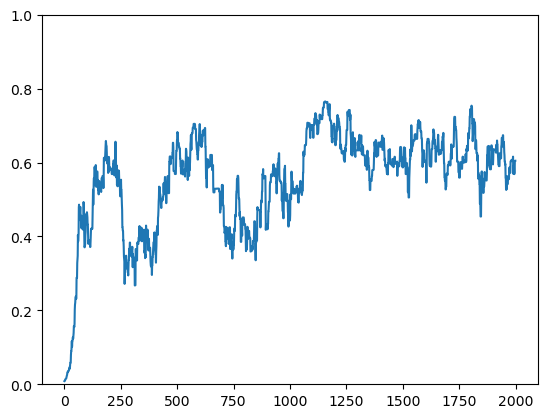

In [309]:
plt.plot(L2)
plt.ylim(0,1)

(0.0, 1.0)

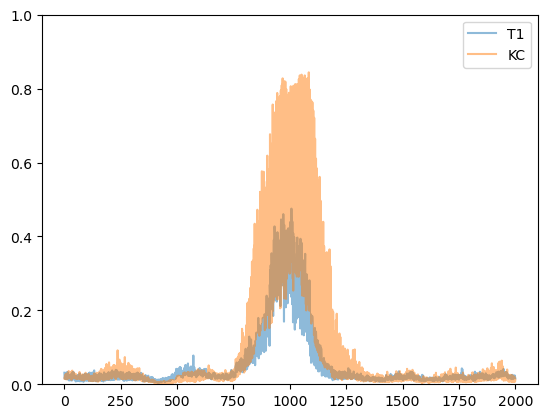

In [308]:
fast_mod_T1=fast_pred_seq(omega_pred,start,modelT1)
fast_mod_KC=fast_pred_seq(omega_pred,start,modelKC)
plt.plot(fast_mod_T1,label='T1',alpha=0.5)
plt.plot(fast_mod_KC,label='KC',alpha=0.5)
plt.legend()
plt.ylim(0,1)
# plt.xlim(900,950)

In [38]:
#weighted probabilities method
rd.seed(0)
Lprob,LsalKC,LsalT1 = [],[],[]
mod_loop=np.copy(X_4_100)
salKC=compute_saliency_channels(mod_loop[start:stop],modelKC)
salKC=salKC - np.mean(salKC, axis=1, keepdims=True)
salKC=np.array(salKC-(salKC*X_4_100[start:stop]))
salKC[salKC<0]=0

salT1=compute_saliency_channels(mod_loop[start:stop],modelT1)
salT1=salT1 - np.mean(salT1, axis=1, keepdims=True)
salT1=np.array(salT1-(salT1*X_4_100[start:stop]))
salT1[salT1<0]=0

mod_sal=salKC*salT1
mod_vals=np.concatenate((np.array(mod_sal[:,0]),np.array(mod_sal[:,1]),np.array(mod_sal[:,2]),np.array(mod_sal[:,3])))
mod_vals_idx=get_max(mod_vals,1)
mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
best_predKC=fast_pred(mod_M_2L[start:stop],modelKC)
best_predT1=fast_pred(mod_M_2L[start:stop],modelT1)
LKC=[] #upgrades
LT1=[] #upgrades
L2KC=[] #pred values
L2T1=[] #pred values
for i in range(600):
    mod_loop=np.copy(mod_M_2L)
    salKC=compute_saliency_channels(mod_loop[start:stop],modelKC)
    salKC=salKC - np.mean(salKC, axis=1, keepdims=True)
    salKC=np.array(salKC-(salKC*X_4_100[start:stop]))
    salKC[salKC<0]=0

    salT1=compute_saliency_channels(mod_loop[start:stop],modelT1)
    salT1=salT1 - np.mean(salT1, axis=1, keepdims=True)
    salT1=np.array(salT1-(salT1*X_4_100[start:stop]))
    salT1[salT1>0]=0

    # sal_loop = salKC*-salT1
    # sal_loop=np.exp(salKC/0.1)*np.exp(-salT1/0.1)
    sal_loop=np.exp(salKC)*np.exp(-salT1)*salKC*salT1
    # sal_loop=sal_loop/sum(sal_loop)
    # sal_loop = np.exp(sal_loop*10 / np.max(sal_loop))
    sal_loop[:900] = 0
    sal_loop[1100:] = 0
    prob = sal_loop / np.sum(sal_loop)
    mod_vals = sal_loop.T.ravel()
    if 400 < i < 500:
        Lprob.append(prob)
        LsalKC.append(salKC)
        LsalT1.append(salT1)
    mod_vals_value=rd.choices(mod_vals, weights=prob.T.ravel(), k=1)
    mod_vals_idx=np.where(mod_vals==mod_vals_value)[0]
    mod_M_2L=aimed_mutation(start,mod_loop,mod_vals_idx)
    
    f_predKC=fast_pred(mod_M_2L[start:stop],modelKC)
    L2KC.append(f_predKC[0,0].numpy())
    if  f_predKC > best_predKC:
        LKC.append(i)
        best_predKC=fast_pred(mod_M_2L[start:stop],modelKC)
        most_pred=mod_M_2L
    
    f_predT1=fast_pred(mod_M_2L[start:stop],modelT1)
    L2T1.append(f_predT1[0,0].numpy())
    if  f_predT1 < best_predT1:
        LT1.append(i)
        best_predT1=fast_pred(mod_M_2L[start:stop],modelT1)
        least_pred=mod_M_2L

In [ ]:
os.chdir('/home/florian/projet/result')
for i in range(99):
    plt.figure(figsize=(15,10))
    plt.scatter(np.array(LsalKC[i])[900:1100],np.array(LsalT1[i])[900:1100],c=Lprob[i][900:1100])
    plt.colorbar()
    plt.savefig('{}.png'.format(i), bbox_inches='tight')
    plt.show()

Text(0.5, 1.0, 'KC*-T1')

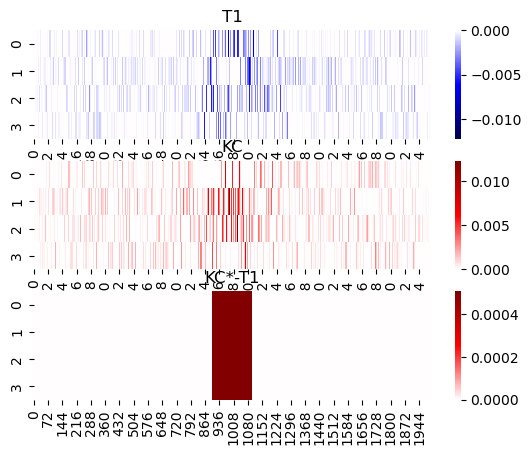

In [145]:
plt.subplot(3,1,1)
sns.heatmap(salT1.T, cmap='seismic',center=0)
plt.title('T1')

plt.subplot(3,1,2)
sns.heatmap(salKC.T, cmap='seismic',center=0)
plt.title('KC')
# plt.xlim(936,1080)

plt.subplot(3,1,3)
sns.heatmap(sal_loop.T, cmap='seismic',center=0)
plt.title('KC*-T1')

<AxesSubplot: >

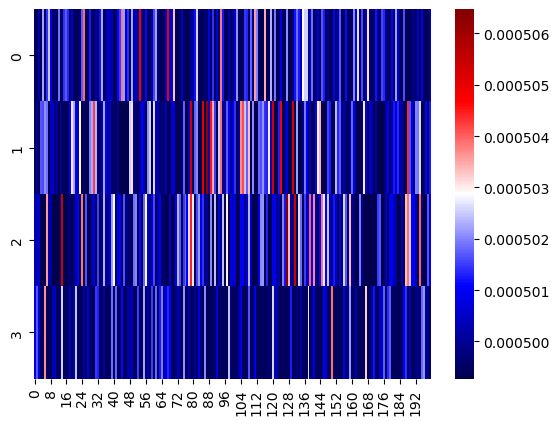

In [146]:
# sal_loop = salKC*-salT1
# sal_loop=np.exp((salKC/0.1)-(salT1/0.001))
# sal_loop[:900] = 0
# sal_loop[1100:] = 0
# prob = sal_loop / np.sum(sal_loop)
sns.heatmap(np.array(sal_loop[900:1100]).T, cmap='seismic')#,center=0)

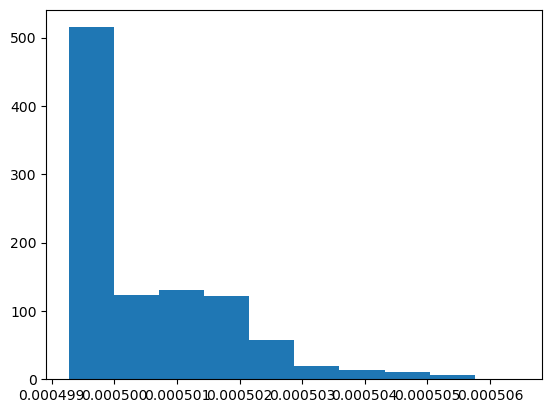

In [129]:
chosen = np.random.choice(sal_loop.ravel(), p=(sal_loop/np.sum(sal_loop)).ravel(), size=1000, replace=True)
plt.hist(chosen)
plt.show()
plt.close()

In [29]:
probsort = np.sort(prob.ravel())[-20:]
print(probsort.sum())
probsort

0.5553783


array([0.01538526, 0.01565153, 0.0156754 , 0.01591374, 0.01684284,
       0.01739257, 0.01854672, 0.01974753, 0.02028971, 0.02158563,
       0.02285282, 0.0234992 , 0.02390537, 0.02561202, 0.02570419,
       0.0281099 , 0.04279244, 0.05115702, 0.05822859, 0.07648588],
      dtype=float32)

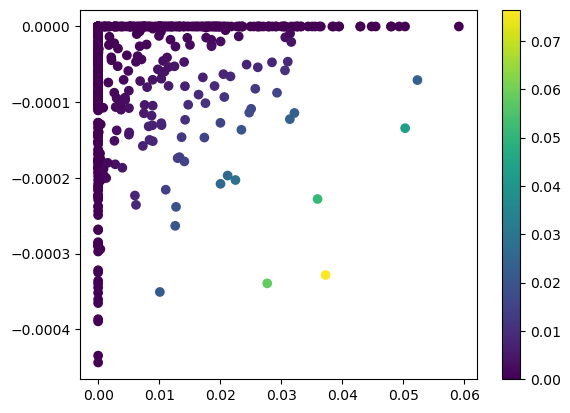

In [27]:
plt.scatter(np.array(salKC)[900:1100],np.array(salT1)[900:1100],c=prob[900:1100])
plt.colorbar()


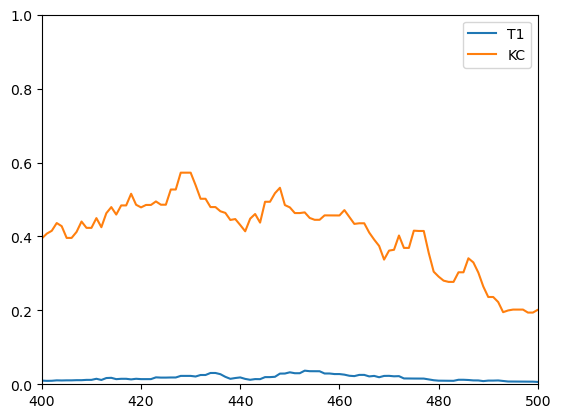

In [46]:
plt.plot(L2T1,label='T1')
plt.plot(L2KC,label="KC")
plt.ylim(0,1)
plt.xlim(400,500)
plt.legend()

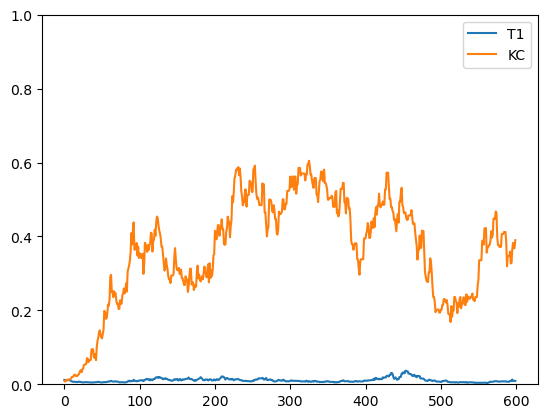

In [47]:
plt.plot(L2T1,label='T1')
plt.plot(L2KC,label="KC")
plt.ylim(0,1)
plt.legend()

In [30]:
fast_mod_T1=fast_pred_seq(most_pred,start,modelT1)
fast_mod_KC=fast_pred_seq(most_pred,start,modelKC)

(0.0, 1.0)

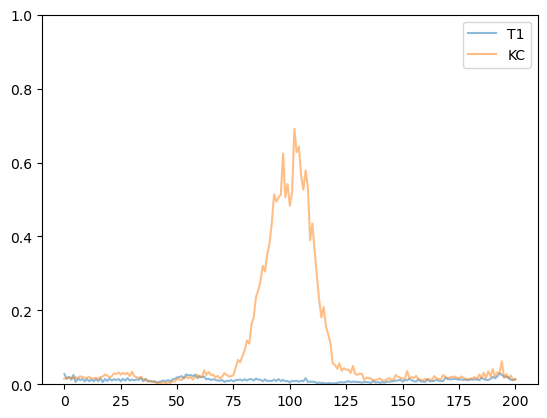

In [31]:
plt.plot(fast_mod_T1[::10],label='T1',alpha=0.5)
plt.plot(fast_mod_KC[::10],label='KC',alpha=0.5)
plt.legend()
plt.ylim(0,1)
# plt.xlim(900,950)